In [1]:
import os
import sys
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import h5py
from pathlib import Path
from torch.utils import data

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [5]:
class CustomDataset(data.Dataset):

    def __init__(self, file_path, transform=None):
        super().__init__()
        self.data_cache = []
        self.transform = transform

        # Search for all h5 files
        p = Path(file_path)
        files = p.glob('*.h5')
        for h5dataset_fp in files:
            with h5py.File(h5dataset_fp.resolve()) as h5_file:
                # Walk through all groups, extracting datasets
                for gname, group in h5_file.items():
                    if gname == 'oneCent':
                        label = 1
                    elif gname == 'twoCent':
                        label = 2
                    elif gname == 'fiveCent':
                        label = 5
                    elif gname == 'twentyCent':
                        label = 20
                    elif gname == 'fiftyCent':
                        label = 50
                    elif gname == 'oneEuro':
                        label = 100
                    elif gname == 'twoEuro':
                        label = 200
                    for dname, ds in group.items():
                        self.data_cache.append([label, np.array(ds[:760000], dtype=np.float32)])
                        #self.data_cache.append([label, torch.tensor((1, ds[:760000]))])
                        
            print(self.data_cache[0][1])

    def __getitem__(self, index):
        return self.data_cache[index]

    def __len__(self):
        return len(self.data_cache)

In [6]:
file_dir = "/home/marcus/Documents/munzwurf/data_normalized"
labels_dir = "/home/marcus/Documents/munzwurf/data/labels.csv"

customData = CustomDataset("/home/marcus/PycharmProjects/pythonProject/")

[ -64. -288. -256. ...   32. -416. -192.]


In [7]:

len(customData)
customData[212]

[5, array([ 224.,   64.,  -96., ..., -576., -160.,   96.], dtype=float32)]

In [8]:
random_indices = np.array(np.floor(np.random.rand(100) * 1000), dtype=int)
#tested a bunch of random indices to get a balanced representation of labels
tested_indices = [ 75, 296, 705, 917, 596, 117, 987, 681, 746, 189, 868, 661, 752, 462, 362, 322,  50,  90,
 526,  53, 15, 403, 881, 226, 428, 453,  80, 312, 486, 690, 842, 959, 247, 224, 748, 772,
 620, 617, 108,  96, 212, 649, 866, 707, 956, 772, 234, 339, 166, 954, 602, 935, 707, 717,
  14, 672, 891, 415, 199, 511,   2, 998, 628, 651,  47, 115, 966,  29,   5, 240, 371,  85,
  18, 997,  68, 170, 325, 807, 378, 566, 763, 121,   3, 442, 674, 938, 393, 763, 755, 336,
 419, 408, 104, 923, 580, 530, 859, 371, 957, 535]


In [9]:
test_labels = np.array([], dtype=int)
test_labels = [i[0] for i in customData[::20]]

In [10]:
train_data = Subset(customData, tested_indices)
test_data = Subset(CustomDataset, np.arange(800, len(customData)))
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=False, num_workers=4)
test_dataloader  = DataLoader(test_data, batch_size=4, shuffle=True, pin_memory=False, num_workers=4)


<BarContainer object of 7 artists>

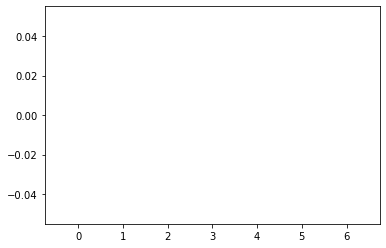

In [11]:
label_count = []
for i in [1,2,5,20,50,100,200]:
    label_count.append(np.count_nonzero(test_labels == i))

plt.bar(range(7), label_count)

In [12]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.conv1 = nn.Conv1d(1, 2, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv1d(2, 4, kernel_size=3, padding=1) 
        self.conv3 = nn.Conv1d(4, 8, kernel_size=3, padding=1) 
        self.conv4 = nn.Conv1d(8, 16, kernel_size=3, padding=1) 
        self.conv5 = nn.Conv1d(16, 32, kernel_size=3, padding=1) 
      
        self.fc1   = nn.Linear(101248, 7)  #262500
     
        
        
    def forward(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)),3)
        #print(x.shape)
        x = F.max_pool1d(F.relu(self.conv2(x)),3)
        #print(x.shape)
        x = F.max_pool1d(F.relu(self.conv3(x)),3)
        #print(x.shape)
        x = F.max_pool1d(F.relu(self.conv4(x)),3)
        #print(x.shape)
        x = F.max_pool1d(F.relu(self.conv5(x)),3)
        #print(x.shape)
        x = torch.flatten(x, 1) 
        print(x.shape)
        x = F.softmax(self.fc1(x), dim=1)
        """
        Size after each layer
        torch.Size([64, 1, 262500])
        torch.Size([64, 1, 131250])
        torch.Size([64, 1, 65625])
        torch.Size([64, 1, 32812])
        torch.Size([64, 1, 16406])
        """
        
        return x

In [13]:
model = Network().to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

Network(
  (conv1): Conv1d(1, 2, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(2, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv5): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=101248, out_features=7, bias=True)
)
710851


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


In [19]:
loss_array = []
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    j = 0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        print(type(data[1]))
        inputs = torch.tensor([1, data[1]])
        labels = data[0]
        print("inputs", inputs[0], "labels", labels[1])
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #loss_array.append(loss.item())
        #loss_plot = plt.plot(range(len(loss_array)), loss_array)
        #plt.show()
        
        # print statistics
        running_loss += loss.item()
        print(loss)
        if i % 5 == 4:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
            print(outputs, labels)

print('Finished Training')

<class 'torch.Tensor'>


ValueError: only one element tensors can be converted to Python scalars